# A simple dust screen

This is the first order correction the vast majority of the literature applies to correct emission line fluxes for dust attenuations. It posits a dust law, and the V-band optical depth is usually obtained from the Balmer decrement (i.e. H$\alpha$/H$\beta$) or another hidrogen line ratio.

In [1]:
# Import main libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
from astropy.table import Table

# Some useful functions for calculations/plots
from natastro import utils
import natastro.plotutils as nplot
from natastro.labels import get_labels

In [2]:
# ===> Set up plots
columnwidth = 240.
textwidth = 504.
screenwidth = 1024.

ps = 'times'
if (ps == 'times'):
    psetup = nplot.plotSetup
    
labels = get_labels(ps)

---
## 1. Reading the data

In [3]:
# Local dir
table_file = 'example_data/SIGNALS_table_spaxels_8247-12704.hdf5'

# Read spaxels table
ts = Table.read(table_file, path='/spaxel')

# Read integrated table (one single row, because we are dealing with a single galaxy)
ti = Table.read(table_file, path='/integrated')

In [4]:
# Emission line quantities start with El_. El_F_6563 = Ha flux; El_eF_6563 = uncertainty Ha flux; etc.
ti

plateid,ifudsgn,mangaid,ra,dec,x0,y0,redshift,pixel_scale_pc,lumDistance_Mpc,x,y,SN,D4000,Lobn,Mcor,Mini,at_flux,at_mass,alogZ_flux,alogZ_mass,tau_V,v_0,v_d,x_Y,flux_unit,El_F_3726,El_EW_3726,El_v0_3726,El_vd_3726,El_vdins_3726,El_lcrms_3726,El_flag_3726,El_F_3729,El_EW_3729,El_v0_3729,El_vd_3729,El_vdins_3729,El_lcrms_3729,El_flag_3729,El_F_4340,El_EW_4340,El_v0_4340,El_vd_4340,El_vdins_4340,El_lcrms_4340,El_flag_4340,El_F_4861,El_EW_4861,El_v0_4861,El_vd_4861,El_vdins_4861,El_lcrms_4861,El_flag_4861,El_F_5007,El_EW_5007,El_v0_5007,El_vd_5007,El_vdins_5007,El_lcrms_5007,El_flag_5007,El_F_6563,El_EW_6563,El_v0_6563,El_vd_6563,El_vdins_6563,El_lcrms_6563,El_flag_6563,El_F_6584,El_EW_6584,El_v0_6584,El_vd_6584,El_vdins_6584,El_lcrms_6584,El_flag_6584,El_F_6716,El_EW_6716,El_v0_6716,El_vd_6716,El_vdins_6716,El_lcrms_6716,El_flag_6716,El_F_6731,El_EW_6731,El_v0_6731,El_vd_6731,El_vdins_6731,El_lcrms_6731,El_flag_6731,El_A_4861,El_AN_4861,El_eF_4861,El_SN_4861,El_A_6563,El_AN_6563,El_eF_6563,El_SN_6563,El_A_3726,El_AN_3726,El_eF_3726,El_SN_3726,El_A_3729,El_AN_3729,El_eF_3729,El_SN_3729,El_A_4340,El_AN_4340,El_eF_4340,El_SN_4340,El_A_5007,El_AN_5007,El_eF_5007,El_SN_5007,El_A_6584,El_AN_6584,El_eF_6584,El_SN_6584,El_A_6716,El_AN_6716,El_eF_6716,El_SN_6716,El_A_6731,El_AN_6731,El_eF_6731,El_SN_6731
int16,int64,bytes9,float64,float64,float32,float32,float32,float32,float32,int16,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
8247,12704,1-137870,136.730098431,44.121516356,18.254055,18.251282,0.0494434,967.25146,219.7264,0,0,12.687684779725029,1.1883676993883459,2379950.0,30941800000.0,55273900000.0,9.095517494117287,9.723635921467427,-0.41088757093992734,-0.5228395800222724,0.1305105230709025,-7.05,77.47,0.07321176103609899,1e-17,743.8332824060375,6.174984018637815,-23.351965645090623,86.41152706623457,86.79411419187491,4.7326837208492325,0,1178.3535248336489,9.74321336816868,-23.351965645090623,86.41152706623457,86.72077671478495,4.7326837208492325,0,378.7611653842843,2.432137887459518,-15.731413715812474,68.51652871540531,77.39375542713617,2.2681950447466015,0,884.4457743871696,5.1548319508780835,-15.731413715812474,68.51652871540531,73.81146871734697,2.2699216531806314,0,496.46166829843014,3.0503682309994646,-16.815366574499784,87.60736973423657,73.13020610719049,1.9964394868207227,0,3421.612793763468,24.954903910057254,-15.731413715812474,68.51652871540531,71.19144060156988,4.487691242975497,0,1105.4684965837976,8.092999413095596,-15.308893819711843,70.65735961816044,71.11109595591358,4.487691242975497,0,706.5657209915797,5.300086613740803,-13.849576837700905,71.32642575608486,70.6104553649397,1.8675898220046057,0,502.56010244004744,3.7808487344140866,-13.849576837700905,71.32642575608486,70.55981257659631,1.8675898220046057,0,216.05842271176945,95.18320705431694,7.105449068882154,124.47429653117094,631.0813960468668,140.62495877689605,16.166885754003896,211.6432840453561,194.94482132740762,41.19117879536365,14.302767935255908,52.00624702666887,308.724958476101,65.23253542510197,14.305072802400607,82.37312323471038,100.96872365095737,44.51500936165629,6.796735107890691,55.7269276162551,103.919180165038

---
## 2. Checking the Balmer decrement

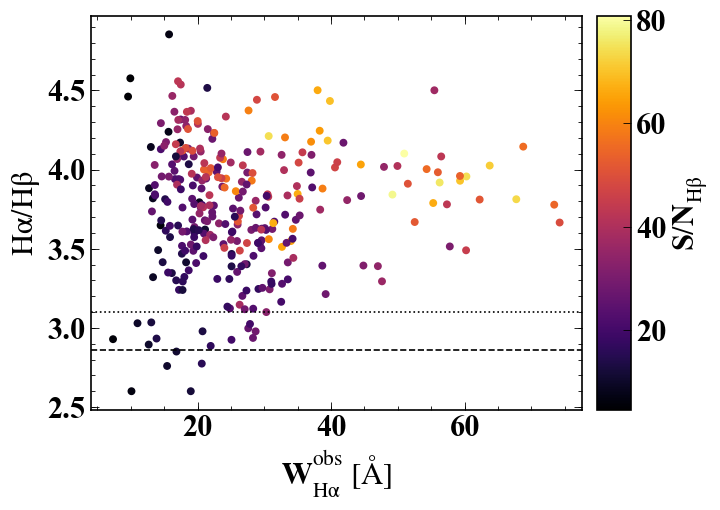

In [5]:
# Plot a classical BPT for the spaxels, colour-coded by EWHa
HaHb = ts['El_F_6563'] / ts['El_F_4861']

psetup(fig_width_pt=textwidth, aspect=1./1.4142, fontsize=22) 
plt.figure()
plt.clf()

gs = gridspec.GridSpec(1, 1)

ax = plt.subplot(gs[0, 0])
im = ax.scatter(ts['El_EW_6563'], HaHb, s=20, c=ts['El_SN_4861'], cmap='inferno')

ax.set_xlabel(nplot.label('El_EW_6563', labels))
ax.set_ylabel(nplot.label('HaHb', labels))
nplot.fix_ticks(ax, ny=5)

ax.axhline(2.86, ls='--', c='k')
ax.axhline(3.10, ls=':' , c='k')

# Add colourbar
cb = nplot.tight_colorbar(im)
cb.set_label(nplot.label('El_SN_4861', labels))

The plot above means we *do* need to correct the emission lines for dust attenuation.

---
## 3. Choosing a dust extinction/attenuation law

In [6]:
# Load a script with a variety of dust laws
from natastro.pycasso2.reddening import calc_redlaw

# Note: This is originally from pycasso2.redenning,
# which can be downloaded at https://bitbucket.org/streeto/pycasso2
# If you have pycasso2 installed, simply use it as
#    from pycasso2.reddening import calc_redlaw

Let us compare the Cardelli, Clayton & Mathis (1989) extinction law with $R_V = 3.1$ the the Calzetti, Kinney & Storchi-Bergmann (1994) attenuation law over a wide wavelength range.

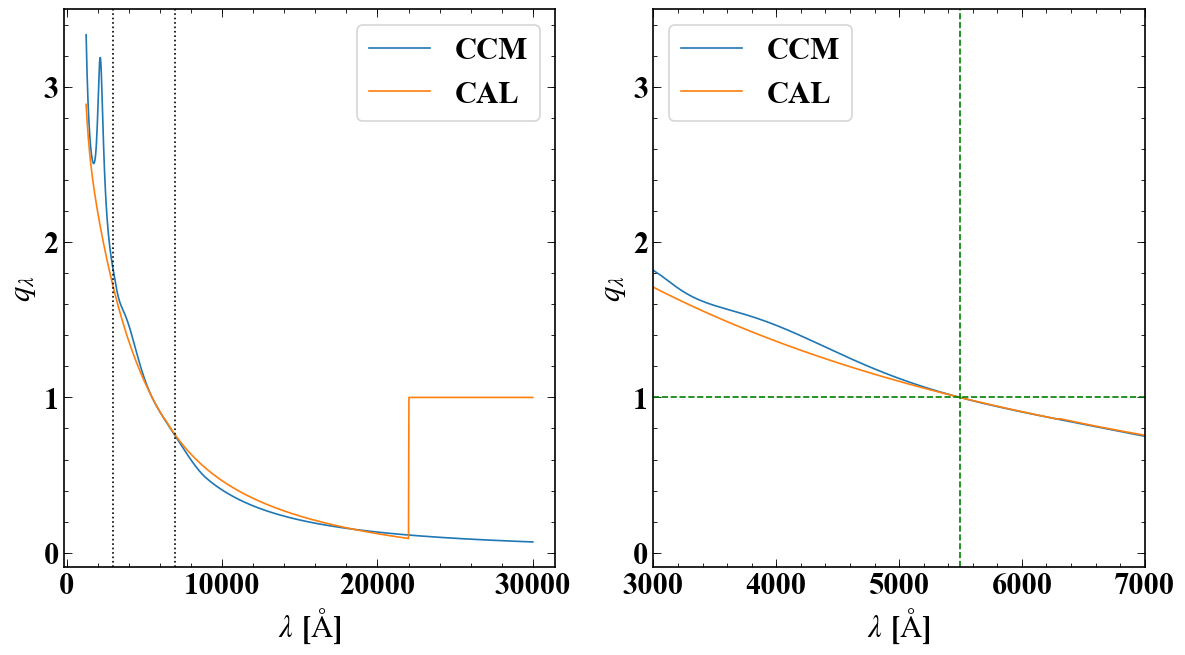

In [7]:
# Define lambdas
ll = np.linspace(1250, 30e3, 1000)

q_CCM = calc_redlaw(ll, 'CCM', R_V=3.1)
q_CAL = calc_redlaw(ll, 'CAL')

# Plot
psetup(fig_width_pt=2*textwidth, aspect=0.5, fontsize=22) 
plt.figure()
plt.clf()

gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0, 0])
plt.plot(ll, q_CCM, label='CCM')
plt.plot(ll, q_CAL, label='CAL')
plt.legend()

ax.set_xlabel(r'$\lambda$ [$\mathrm{\AA}$]')
ax.set_ylabel(r'$q_\lambda$')
nplot.fix_ticks(ax, ny=5)

ax.axvline(3000, ls=':', c='k')
ax.axvline(7000, ls=':', c='k')

# Zooming into the optical
ax = plt.subplot(gs[0, 1])
plt.plot(ll, q_CCM, label='CCM')
plt.plot(ll, q_CAL, label='CAL')
plt.legend()
plt.xlim(3000, 7000)

ax.set_xlabel(r'$\lambda$ [$\mathrm{\AA}$]')
ax.set_ylabel(r'$q_\lambda$')
nplot.fix_ticks(ax, ny=5)

ax.axhline(1, ls='--', c='green')
ax.axvline(5500, ls='--', c='green')

---
## 4. Calculating the optical depth

Let us take the CCM law with $R_V = 3.1$ to correct our emission line fluxes. Assuming a screen of dust, the observed flux at a given wavelength $\lambda$ ($F_\lambda$) is related to the intrinsic flux ($F_{\lambda,0}$) by
\begin{align}
F_{\lambda} = F_{\lambda,0} \; e^{-\tau_\lambda} = F_{\lambda,0} \; e^{-\tau_V q_\lambda},
\end{align}

where we have defined $\tau_\lambda \equiv \tau_V q_\lambda$.

Let us take the intrinc Balmer decrement to be $(F_{\mathrm{H\alpha},0} / F_{\mathrm{H\beta},0}) = 2.87$, which assumes Case B and a 10,000 K nebula. We can write
\begin{align}
   F_\mathrm{H\alpha} &= F_{\mathrm{H\alpha},0} \; e^{ -\tau_V q_\mathrm{H\alpha} },
\\ F_\mathrm{H\beta } &= F_{\mathrm{H\beta },0} \; e^{ -\tau_V q_\mathrm{H\beta } },
\end{align}
Taking the ratio of the two equations and rearranging the terms to isolate the optical depth at the $V$-band,
\begin{align}
\tau_V &= \frac{1}{q_\mathrm{H\beta} - q_\mathrm{H\alpha}} \; 
          \ln \frac{F_\mathrm{H\alpha} / F_\mathrm{H\beta}}{F_{\mathrm{H\alpha},0}/F_{\mathrm{H\beta },0}}
\end{align}
Therefore, we need the $q$'s for $\mathrm{H\alpha}$ and $\mathrm{H\beta}$, which come from the dust law we have chosen, and the observed and intrinc Balmer decremets.

In [8]:
qHb, qHa = calc_redlaw([4861, 6563], 'CCM', R_V=3.1)
B = 2.87
tauV = (qHb - qHa)**-1 * np.log(HaHb / B)

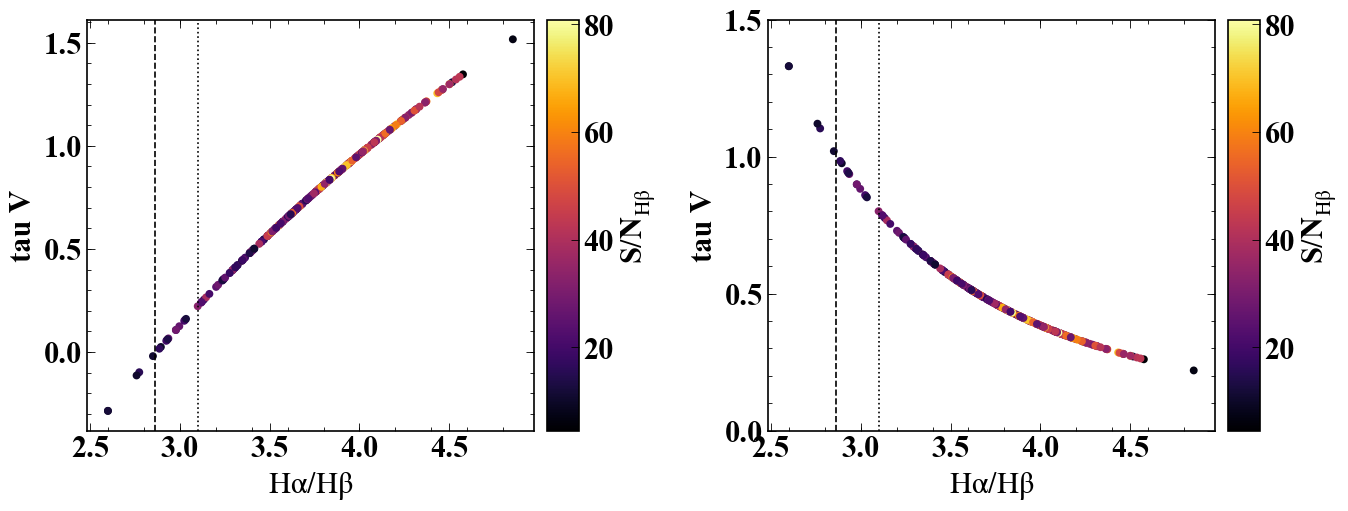

In [9]:
# Checking our tau_V
psetup(fig_width_pt=2*textwidth, aspect=0.4, fontsize=22) 
plt.figure()
plt.clf()

gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0, 0])
im = ax.scatter(HaHb, tauV, s=20, c=ts['El_SN_4861'], cmap='inferno')

ax.set_xlabel(nplot.label('HaHb', labels))
ax.set_ylabel(nplot.label('tau_V', labels))
nplot.fix_ticks(ax, ny=4)

ax.axvline(2.86, ls='--', c='k')
ax.axvline(3.10, ls=':' , c='k')

# Add colourbar
cb = nplot.tight_colorbar(im)
cb.set_label(nplot.label('El_SN_4861', labels))


# This plot may give a better physical intuition
ax = plt.subplot(gs[0, 1])
im = ax.scatter(HaHb, np.exp(-tauV), s=20, c=ts['El_SN_4861'], cmap='inferno')

ax.set_xlabel(nplot.label('HaHb', labels))
ax.set_ylabel(nplot.label('tau_V', labels))
nplot.fix_ticks(ax, ny=4)
plt.ylim(0, 1.5)

ax.axvline(2.86, ls='--', c='k')
ax.axvline(3.10, ls=':' , c='k')

# Add colourbar
cb = nplot.tight_colorbar(im)
cb.set_label(nplot.label('El_SN_4861', labels))

plt.tight_layout()

Combining $\tau_V$ with our chosen dust law, we can see how much/how little light is lost at each $\lambda$. Let us compare $\tau$ at $3000$ and at $7000$ $\AA$.

In [10]:
q3000, q7000 = calc_redlaw([3000, 7000], 'CCM', R_V=3.1)

tau3000 = tauV * q3000
tau7000 = tauV * q7000

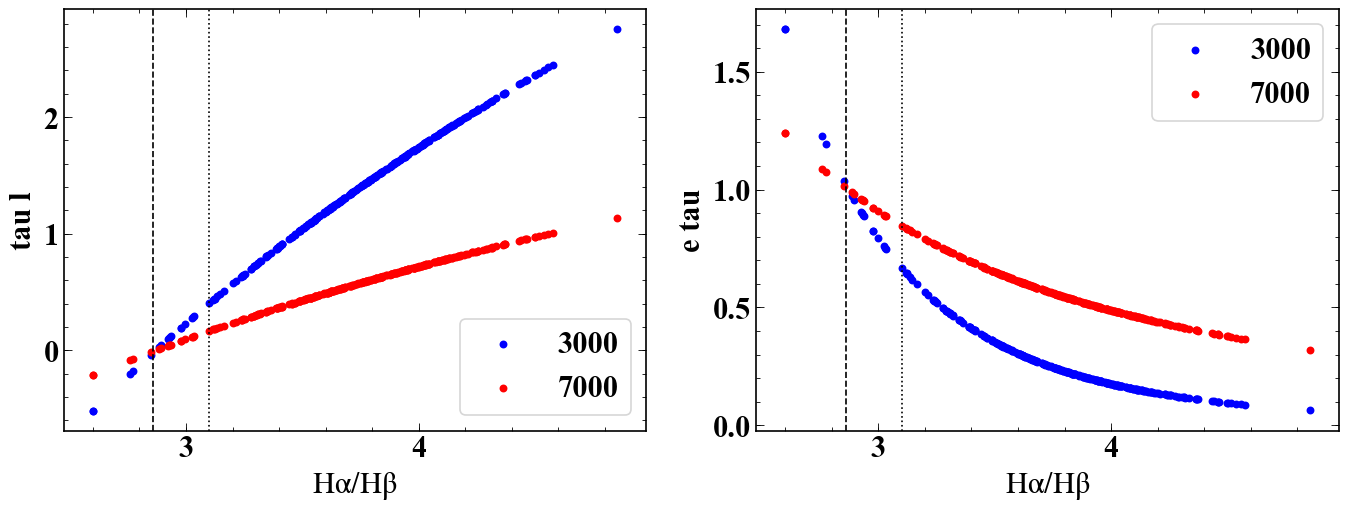

In [11]:
# Checking our tau_3000, tau_7000
psetup(fig_width_pt=2*textwidth, aspect=0.4, fontsize=22) 
plt.figure()
plt.clf()

gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0, 0])
ax.scatter(HaHb, tau3000, s=20, c='blue', label='3000')
ax.scatter(HaHb, tau7000, s=20, c='red' , label='7000')
plt.legend()

ax.set_xlabel(nplot.label('HaHb', labels))
ax.set_ylabel(nplot.label('tau_l', labels))
nplot.fix_ticks(ax, ny=4)

ax.axvline(2.86, ls='--', c='k')
ax.axvline(3.10, ls=':' , c='k')


# This plot may give a better physical intuition
ax = plt.subplot(gs[0, 1])
ax.scatter(HaHb, np.exp(-tau3000), s=20, c='blue', label='3000')
ax.scatter(HaHb, np.exp(-tau7000), s=20, c='red' , label='7000')
plt.legend()

ax.set_xlabel(nplot.label('HaHb', labels))
ax.set_ylabel(nplot.label('e_tau', labels))
nplot.fix_ticks(ax, ny=4)

ax.axvline(2.86, ls='--', c='k')
ax.axvline(3.10, ls=':' , c='k')


plt.tight_layout()

---
## 5. Dereddening emission lines

Now we know how to obtain $\tau_\lambda$, we simply need to calculate:
\begin{align}
F_{\lambda,0} = F_{\lambda} \; e^{+\tau_\lambda}.
\end{align}

In [12]:
tauHa = tauV * qHa
ts['El_F_6563_dr'] = ts['El_F_6563'] * np.exp(tauHa)

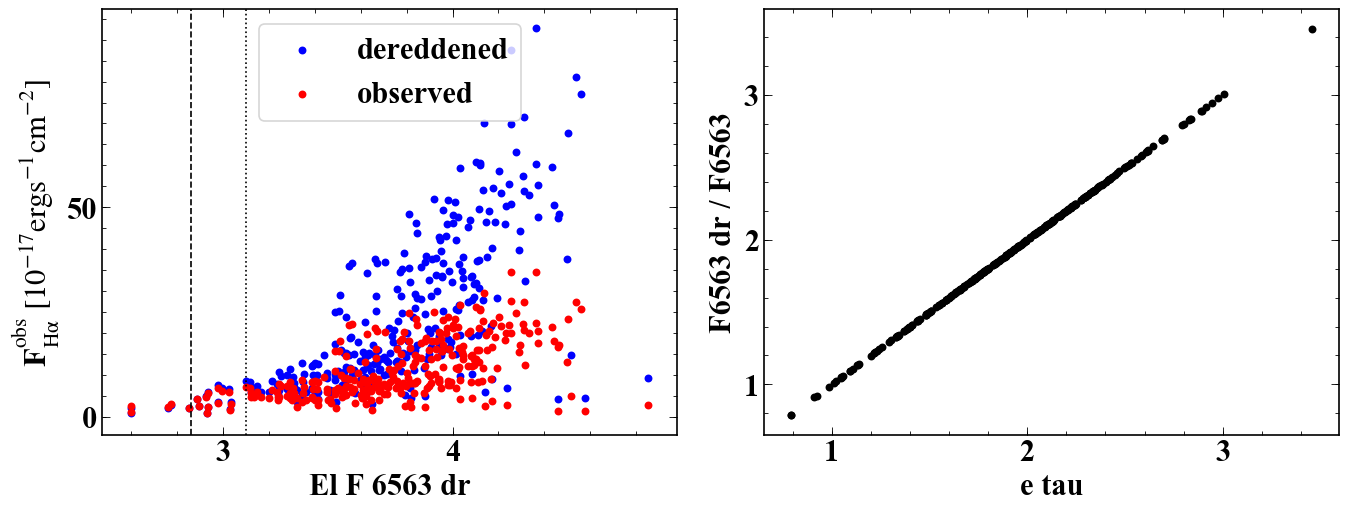

In [13]:
# Checking dereddened Ha flux
psetup(fig_width_pt=2*textwidth, aspect=0.4, fontsize=22) 
plt.figure()
plt.clf()

gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0, 0])
ax.scatter(HaHb, ts['El_F_6563_dr'], s=20, c='blue', label='dereddened')
ax.scatter(HaHb, ts['El_F_6563'   ], s=20, c='red' , label='observed')
plt.legend()

ax.set_xlabel(nplot.label('El_F_6563_dr', labels))
ax.set_ylabel(nplot.label('El_F_6563', labels))
nplot.fix_ticks(ax, ny=4)

ax.axvline(2.86, ls='--', c='k')
ax.axvline(3.10, ls=':' , c='k')

# Double-checking
ax = plt.subplot(gs[0, 1])
ax.scatter(np.exp(tauHa), ts['El_F_6563_dr']/ts['El_F_6563'], s=20, c='k')

ax.set_xlabel(nplot.label('e_tau', labels))
ax.set_ylabel(nplot.label('F6563_dr / F6563', labels))
nplot.fix_ticks(ax, ny=4)

plt.tight_layout()

In [14]:
# Now let us write up a more generic code and deredden a bunch of emission lines at once
def deredden_line(ll, tauV):
    q_l = calc_redlaw([ll], 'CCM', R_V=3.1)[0]
    tau_l = tauV * q_l
    ts[f'El_F_{ll}_dr'] = ts[f'El_F_{ll}'] * np.exp(tau_l)
    
for ll in [3726, 3729, 4861, 5007, 6563, 6584]:
    deredden_line(ll, tauV)
    
    
# Get info for 3727
ts['El_F_3727'] = utils.safe_sum( ts['El_F_3726'], ts['El_F_3729'] )
ts['El_F_3727_dr'] = utils.safe_sum( ts['El_F_3726_dr'], ts['El_F_3729_dr'] )

# Common line ratios
log_O3Hb = utils.safe_log10( utils.safe_div(ts['El_F_5007'], ts['El_F_4861']) )
log_N2Ha = utils.safe_log10( utils.safe_div(ts['El_F_6584'], ts['El_F_6563']) )
O23 = utils.safe_log10( utils.safe_div( utils.safe_sum(ts['El_F_5007'] * 1.34, ts['El_F_3727']), ts['El_F_4861'] ) )
O3O2 = utils.safe_log10( utils.safe_div( ts['El_F_5007'] * 1.34, ts['El_F_3727']) )
log_O3N2 = utils.safe_sub( log_O3Hb, log_N2Ha )

log_O3Hb_dr = utils.safe_log10( utils.safe_div(ts['El_F_5007_dr'], ts['El_F_4861_dr']) )
log_N2Ha_dr = utils.safe_log10( utils.safe_div(ts['El_F_6584_dr'], ts['El_F_6563_dr']) )
O23_dr = utils.safe_log10( utils.safe_div( utils.safe_sum(ts['El_F_5007_dr'] * 1.34, ts['El_F_3727_dr']), ts['El_F_4861_dr'] ) )
O3O2_dr = utils.safe_log10( utils.safe_div( ts['El_F_5007_dr'] * 1.34, ts['El_F_3727_dr']) )

## 6. Checking the effect of dereddening

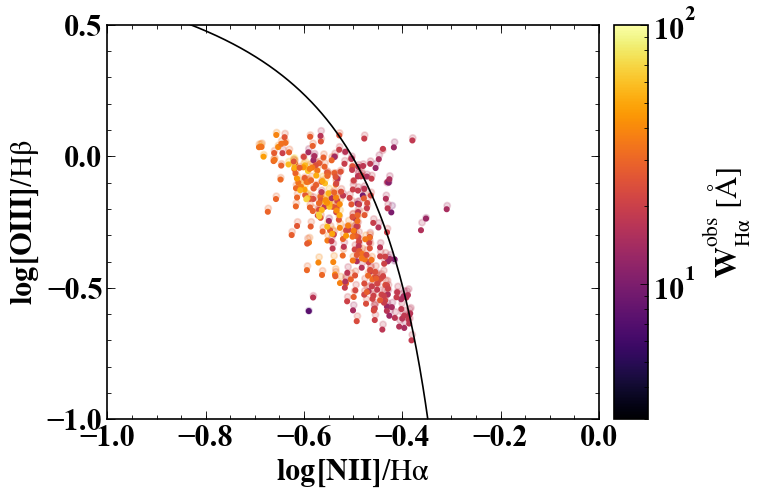

In [15]:
# Classical BPT
import matplotlib.colors as colors

# Defining BPT lines
Kewl_O3Hb = lambda N2Ha: np.where( (N2Ha > -999) & (N2Ha <  0.47), 1.19 + 0.61 / (N2Ha - 0.47) , -999.)
Kauf_O3Hb = lambda N2Ha: np.where( (N2Ha > -999) & (N2Ha <  0.05), 1.30 + 0.61 / (N2Ha - 0.05) , -999.)
Graz_O3Hb = lambda N2Ha: np.where( (N2Ha > -999) & (N2Ha < -0.20), 0.96 + 0.29 / (N2Ha + 0.20) , -999.)

psetup(fig_width_pt=textwidth, aspect=1./1.4142, fontsize=22) 
plt.figure()
plt.clf()

gs = gridspec.GridSpec(1, 1)

ax = plt.subplot(gs[0, 0])
# Original 
im = ax.scatter(log_N2Ha, log_O3Hb, s=20, c=ts['El_EW_6563'], alpha=0.2, cmap='inferno', vmin=3, vmax=100, norm=colors.LogNorm())
# Dereddened 
im = ax.scatter(log_N2Ha_dr, log_O3Hb_dr, s=10, c=ts['El_EW_6563'], cmap='inferno', vmin=3, vmax=100, norm=colors.LogNorm())
ax.set_xlabel(nplot.label('log_N2Ha', labels))
ax.set_ylabel(nplot.label('log_O3Hb', labels))

# Plot S06 line
x = np.linspace(-2, -0.3, 1000)
plt.plot(x, Graz_O3Hb(x), 'k')
plt.xlim(-1, 0.)
plt.ylim(-1, 0.5)
nplot.fix_ticks(ax, ny=5)

# Add colourbar
cb = nplot.tight_colorbar(im)
cb.set_label(nplot.label('El_EW_6563', labels))

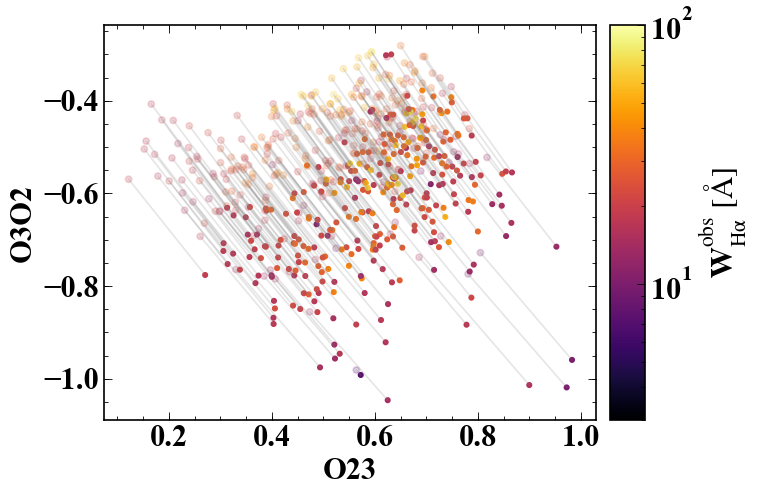

In [16]:
# MacGaugh 1991 plot: O23 vs O3O2
import matplotlib.colors as colors

psetup(fig_width_pt=textwidth, aspect=1./1.4142, fontsize=22) 
plt.figure()
plt.clf()

gs = gridspec.GridSpec(1, 1)

ax = plt.subplot(gs[0, 0])
# Original 
im = ax.scatter(O23, O3O2, s=20, c=ts['El_EW_6563'], alpha=0.2, cmap='inferno', vmin=3, vmax=100, norm=colors.LogNorm())
# Dereddened 
im = ax.scatter(O23_dr, O3O2_dr, s=10, c=ts['El_EW_6563'], cmap='inferno', vmin=3, vmax=100, norm=colors.LogNorm())

# Connect points
for x1, y1, x2, y2 in zip(O23, O3O2, O23_dr, O3O2_dr):
    plt.plot((x1, x2), (y1, y2), 'grey', alpha=0.2)

ax.set_xlabel(nplot.label('O23', labels))
ax.set_ylabel(nplot.label('O3O2', labels))
nplot.fix_ticks(ax, ny=5)

# Add colourbar
cb = nplot.tight_colorbar(im)
cb.set_label(nplot.label('El_EW_6563', labels))